In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Admissions Predictors

In [3]:
aux = pd.read_csv('data.csv',  index_col=0, parse_dates=[0])
df = pd.DataFrame(aux['occupancy'])

df = df.tail(int(0.8*len(df)))

## The Real Deal

In [4]:
def decomp(df, p):
    df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
    df['r_occupancy'] = df['occupancy']-df['s_occupancy']
    aux_df = df.dropna()
    return df, aux_df

In [5]:
def xy_matrices(df, key,q, l, transform = False):  
    predictors_dict = {}
    for i in range(len(df)-(q+l-1)):
        predictors_dict[i] = df[key].iloc[i:i+q+l].values #the 1 is actually l
        
    predictors = pd.DataFrame(predictors_dict).T 
    
    if transform :
        predictors = transform(predictors) 
    
    y = predictors[np.arange(q, q+l, 1)].values #here I need l dependence 
    x_predictors = predictors.drop(np.arange(q, q+l, 1), axis=1).values #here too
    
    return x_predictors, y

In [6]:
def transform(df): #acts on dataframes, scaler is global function/variable
    X = df.values
    X = scaler.fit_transform(X)
    return pd.DataFrame(X)

In [7]:
def inverse_transform(X, y): #acts on arrays, scaler is global function/variable
    aux = np.column_stack((X,y)) 
    aux = scaler.inverse_transform(aux)
    return aux[:,-1]

In [8]:
def chrono_split(X,y, f):
    l = len(y)
    X_train = X[0:int(f*l)]
    X_test = X[int(f*l):]
    y_train = y[0:int(f*l)]
    y_test = y[int(f*l):]
    return X_train, X_test, y_train, y_test

In [9]:
def max_error(y_test, y_forecast):
    return  np.max(np.abs(y_test-y_forecast))
def abs_error(y_test, y_forecast):
    return np.mean(np.abs(y_test-y_forecast))
def rsm_error(y_test, y_forecast):
    return np.sqrt(np.sum((y_test-y_forecast)**2))/np.sqrt(len(y_test))

In [10]:
model_linear = linear_model.LinearRegression()
model_nene = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-9,
                    hidden_layer_sizes=(350, 350), random_state=0,
                    max_iter=2000,  warm_start=True)
model_tree = tree.DecisionTreeRegressor()
model_gbr = GradientBoostingRegressor(n_estimators=750, learning_rate=0.1,
                                      max_depth=1, random_state=0, loss='ls',
                                      warm_start=True)
model_svr = svm.SVR(gamma='auto')

scaler = StandardScaler()

In [11]:
models = {'linear':model_linear ,'nene': model_nene, 'tree': model_tree, 
          'gbr': model_gbr, 'svr': model_svr}
errors = {'max':max_error ,'abs': abs_error, 'rsm':rsm_error}

## Linear Model

In [12]:
l = 7#forecast
q = 35 #lagging

f = 0.70
X, y = xy_matrices(df,'occupancy' ,q, l, False)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [13]:
trials = {}
ntrials = 300

In [14]:
for i in range(0,ntrials):
    mask = np.random.binomial(1,0.8, X_train.shape[0])
    training = X_train[mask == 1]
    target = y_train[mask == 1]
    
    trials[i] =  models['linear'].fit(training, target)

/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [15]:
walks = {}
for i in range(0,ntrials):
    walks[i] = trials[i].predict(X_test)

In [16]:
prior = df.head(X_train.shape[0]).values
aux_1 = np.append(prior, y_test[0,:])

l_aux = int(0.95*len(aux_1))
y_aux = np.linspace(1, len(aux_1), len(aux_1))

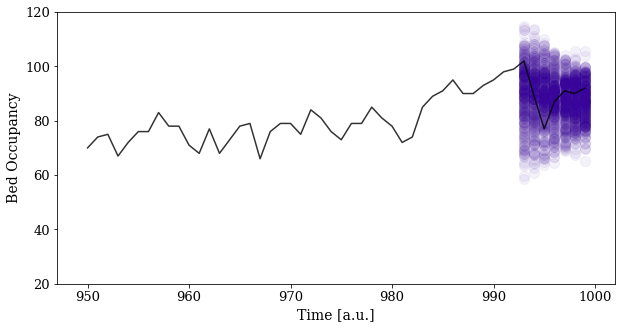

In [17]:
cmap = cm.plasma
colors = np.linspace(0,0.95, ntrials)

plt.figure(figsize=(10,5))
plt.plot(y_aux[l_aux:], aux_1[l_aux:], color='black', alpha = 0.80)

for i in range(0, ntrials):
    aux_2 = np.append(np.zeros(len(prior)), walks[1][i,:])
    plt.scatter(y_aux[l_aux:], aux_2[l_aux:], color = cmap(colors[25]) , alpha = 0.05, s = 100)

plt.ylim([20,120])
plt.xlabel('Time [a.u.]', fontsize=14)
plt.ylabel('Bed Occupancy', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

## Random Walk

In [18]:
l = 1#forecast
q = 35 #lagging

f = 0.70
X, y = xy_matrices(df,'occupancy' ,q, l, False)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [19]:
p = 30
df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
df['r_occupancy'] = df['occupancy']-df['s_occupancy']

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [20]:
X_r, y_r = xy_matrices(df,'r_occupancy' ,q, l, False)
X_train_r, X_test_r, y_train_r, y_test_r = chrono_split(X, y, f)

sigma = np.std(y_train_r)

In [ ]:
for model in models:
    models[model].fit(X_train, y_train)

/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
ntrials = 300

In [ ]:
prob_dist = {}

for trial in range(ntrials):
    step = X_test[-1,:]
    random_walk = np.array([])
    for day in range(0,X_test.shape[0]):
        dy = np.random.normal(loc=0, scale = sigma)
        y_rw = models['nene'].predict(step.reshape(1,-1))[0]
        step = np.append(step[1:], y_rw) + 0.1*dy
        random_walk = np.append(random_walk, y_rw)

    prob_dist[trial] = random_walk

In [ ]:
prior = df.head(X_train.shape[0]).values
aux_1 = np.append(prior, y_test[0,:])

In [ ]:
cmap = cm.plasma
colors = np.linspace(0,0.75, 100)

plt.figure(figsize=(12,5))
for trial in range(100):
    aux_2 = np.append(np.zeros(len(prior)), prob_dist[trial][0:7])
    plt.scatter(y_aux[l_aux:], aux_2[l_aux:], color=cmap(colors[trial]), alpha = 0.05, s = 100)
    
plt.plot(y_aux[l_aux:], aux_1[l_aux:], color='black', alpha = 0.80)


plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best', fontsize=12)
plt.title('Random Walk Forecasting', fontsize = 14)
plt.ylim([60,130])
#plt.xlim([900,1400])
plt.show()